<center><h1>Algorithmic Data Science - Assessed Coursework<h1></center>

### Preliminary Imports##

In [1]:
import sys
import time
import numpy as np
from scipy import stats
from statistics import mean
from IPython.display import Image
sys.path.append(r'\\ad.susx.ac.uk\ITS\TeachingResources\Departments\Informatics\LanguageEngineering\resources')
sys.path.append(r'/Users/juliewe/resources')
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
from sussex_nltk.corpus_readers import ReutersCorpusReader
from sussex_nltk.corpus_readers import MedlineCorpusReader
from sussex_nltk.corpus_readers import TwitterCorpusReader
from sussex_nltk.corpus_readers import WSJCorpusReader
from IPython.display import clear_output
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import pandas as pd
import random
import string
import math

Sussex NLTK root directory is \\ad.susx.ac.uk\ITS\TeachingResources\Departments\Informatics\LanguageEngineering\resources


<h1>Introduction<h1>

$\qquad$Since the focus of our investigation is going to be centred around the various running times of different algorithms that operate on documents of words, the cell below contains 3 methods used to generate random document collection lists from random (nonesensical) words. This is appropriate as it gives us complete control over any aspect of the algorithms input size (word length, doc length, collection size), allowing us to perform the in depth run-time anaylsis necessary over a full range of possible input data. We will be focusing on algorithms that calculate similarity measures between documents, yet this approach is still suitable as it is the running-times we are primarily concerned with, as opposed to the similarity measures themselves which will of course suffer as a result.

An added benefit of this approach over a real text corpora is that it is highly unlikely that the same word will occur twice in a document:

$$\displaystyle\sum_{n=1}^{docLen-1} \frac{n}{26^{wordLen}}$$

$\qquad$With a document length of 50, and word length of 10, this equates to only a $8.6 \times 10^{-12}$ chance that not all words are unique. This is advantageous for investigating the theoretical worst-case running times when documents are represented as dictionaries, as it leads to the most sparse representation possible.

In [205]:
#Creates a random (nonesensical) word, as string
def randomWord(length=10):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))

#Creates a document of random words, stored as dict
def randomDoc(length=50):
    doc = {}
    for i in range(length):
        word = randomWord()
        doc[word] = doc.get(word,0)+1
    return doc

#Creates a collection (list) of documents, all of the same length
def fixedCollection(size=10):
    docs = []
    for i in range(size):
        docs.append(randomDoc())
    return docs

#Creates a collection (list) of documents of varying length
def plottableCollection(maxDocSize=1000, increment=10):
    docs = []
    for i in range(1, maxDocSize, increment):
        docs.append(randomDoc(i))
    return docs

$\qquad$Although it is the running-times we will be investigating, we do want to ensure that our implementations of the algorithms work as desired. Since any similarity measures between documents generated above will be 0, the code below creates a bag-of-words collection from a sample of 5 different corpora which will allow me to more accurately determine the correctness of our implementations.

In [28]:
wsj = WSJCorpusReader()
medline = MedlineCorpusReader()
amazon = AmazonReviewCorpusReader()
reuters = ReutersCorpusReader()
twitter = TwitterCorpusReader()

collectionsize=200 #Specifies the maximum amount of documents that can be sampled from each corpus
collections={"wsj":[],"medline":[], "amazon":[], "reuters":[], "twitter":[]}

for key in collections.keys():
    if key=="wsj":
        generator=wsj.raw()
    elif key=="medline":
        generator=medline.raw()
    elif key=="amazon":
        generator=amazon.raw()
    elif key=="reuters":
        generator=reuters.raw()
    elif key=="twitter":
        generator=twitter.raw()
        
    while len(collections[key])<collectionsize:
        collections[key].append(next(generator))
        
def make_bow(string):
    """
    A function to transform a document from a string representation to a bag-of-words representation, stored in a dictionary
    Params: string - document represented as a string
    Return: dict_rep - the dictionary representation of the same document as a bag-of-words
    """
    dict_rep={}
    rep=word_tokenize(string)
    for token in rep:
        dict_rep[token]=dict_rep.get(token,0)+1
    return(dict_rep)

bow_collections={key:[make_bow(doc) for doc in collection] for key,collection in collections.items()}
string_collections={key:[doc for doc in collection] for key,collection in collections.items()}

$\qquad$Whilst the code above creates a bag-of-words collection of the specified amount of documents (`collectionsize`) from each corpora, the function below creates a new list which is a vetted sub-group of these, ensuring every member document meets a minimum word requirement, defaulted at 50 as per the problem specification. 
Although the code block above may take a while to execute depending on the collectionsize and amount of corpora being considered, it must only be run once, thereafter `populate-doc-collection` can be used with great speed and efficiency. 

In [29]:
def populate_doc_collection(corpus, docCount=10, minimumWords=50, maxWords=9999):
    """
    This function populates a list with the specified amount of documents (defaults to 10) from the given corpus, 
    each of which has at least 50 words, as per the problem specification.
    Params: corpus - the corpus from which the sentences are sampled
            docCount - the amount of documents to include in the returned collection (default = 10)
    Return: docs - a list of documents (each of which is represented as a dictionary with >= 50 words)
    """
    docs = []
    index = 0
    while len(docs) < docCount:
        wordCount = sum(bow_collections[corpus][index].values())
        if wordCount >= minimumWords and wordCount < maxWords: #Minimum word count per document
            docs.append(bow_collections[corpus][index])  
        index += 1    
    return docs

### 1)  What is the theoretical worst case running time of Jaccard’s similarity measure applied to documents represented as bags of words? Show that this is the case empirically. Estimate the constant for your implementation and computer. ###

$\qquad$In order to calculate the Jaccard's similarity of two documents, `doc1` and `doc2`, every word in `doc1` must be iterated through, and for each one, its presence must be checked for in `doc2`. Although in its average case, an `x in y` operation with a python dictionary could be described to have a constant runtime, it is $O(n)$ in its worst case (in the very unlikely event that all keys have the same hash), where $n$ is the number of words in `y`, which in our case is `doc2`.

$\qquad$The theoretical worst-case running time of Jaccard's similarity can therefore be described as $n\cdot m$, where $n$ and $m$ denote the number of words in each of the respective bag-of-words representations being compared. This can be characterised as $n^2$ in the cases where $m \geqslant n$, or $m^2$ otherwise - however these variable names are arbitrary and so that would not affect the $O(n^2)$ running time.

$\qquad$To empirically show that this is the case, I created a variable called `totalOperations` that is incremented with every comparison. You can see that this always totals exactly $m \cdot n$, proving the quadratic $O(n^2)$ runtime, and this holds true regardless of which 2 documents are compared. This value would be an order of magnitude smaller in the case of a linear runtime. It must be noted that I modified the code from the `if x in y` statement to a conditional loop to allow me to increment the `totalOperations` variable in a mannor that reflects every comparison made in the theoretical worst-case, when needed.

In [204]:
#Populates our document collection with 10 samples from the amazon review corpus
docs = populate_doc_collection('amazon')
doc1 = docs[0]
doc2 = docs[1]

def maketotal(dict1):
    """
    This function totals all the word frequencies in a given document (from lab_6 solutions)
    Params: dict1 - the document to be totalled, represented as a bag-of-words dictionary
    Return: total - the total amount of words in dict1, as an integer
    """
    total=0
    for item in dict1:
        total += dict1[item]
    return total

def jaccard(dict1,dict2, worstCase=False):
    """
    This function calculates the Jaccard's Similarity measure of the two given documents (adapted from lab_6 solutions)
    Params: dict1, dict2 - the two documents to be compared, each represented as a bag-of-words dictionary
    Return: - the Jaccard's similarity of the two given documents
    """
    totalOperations = 0 
    intersection={} #Initializes dictionary to store overlapping words + frequency
    for item1 in dict1.keys():
        ## If statement replaces 'if x in y' statement to give more accurate under the hood view of worst case running times
        if worstCase:
            for item2 in dict2.keys():
                if item1 == item2:
                    #Takes minimum val of frequencies in either doc as intersection freq
                    intersection[item1]=min(dict1[item1],dict2[item1]) 
                totalOperations += 1   
        else: #In an average case
            if item1 in dict2.keys(): #Check if also appears in doc2
                #Takes minimum val of frequencies in either doc as overlap
                intersection[item1]=min(dict1[item1],dict2[item1])            
            
    intersectiontot=maketotal(intersection) #Totals all frequencies of overlapped words
    union = maketotal(dict1)+maketotal(dict2)-intersectiontot #Total words in both docs minus no of overlapping words (union)
    #Returns jaccards as well as totalOperations, to allow totalOps to be printed outside the function
    return [round(intersectiontot/(union+0.1),4), totalOperations] #Proportion of overlapping words to union of each doc (Jaccards)

#Textual output and empirical evidence of running time
print("Jaccard's similarity: ", jaccard(doc1,doc2)[0])
print("Total operations: ", jaccard(doc1,doc2, True)[1])
print("Length of doc1: ", len(doc1))
print("Length of doc2: ", len(doc2))
print(len(doc1), " * ", len(doc2), " = ", len(doc1)*len(doc2))

Jaccard's similarity:  0.1657
Total operations:  6480
Length of doc1:  81
Length of doc2:  80
81  *  80  =  6480


$\qquad$Whilst the above output serves as empirical evidence to support the theoretical worst-case running time, the purpose of code below is to demonstrate it in practice. You may notice that every plotted similarity is calculated between two instances of the same document, this is because we are purely interested in the running-times, not the similarity scores, and doing so allowed me to make much better use of any given amount of input data, spanning the full range of document word counts. Below you see the definition of a function that I will be making significant use of in cases where I wish to visualise running times with a graph.

In [126]:
#-----------------------------------------Plot as a function-----------------------------------------------------------------
def plot_runtime(algorithm, representation, docSizeLim=1000, increment=10, title='', xlabel='', ylabel='', worstCase=False):
    times, docSizes = [], []
    docs = plottableCollection(docSizeLim, increment)

    for x in range(len(docs)-1): #iterates through every document
        clear_output(wait=True)
        
        #Representation specific operators to total all words for X-axis values
        if representation == 'dict':
            docSizes.append(sum(docs[x].values()))
        elif representation == 'vector':
            amatrix=make_matrix([docs[x]])
            docvectors=transpose(amatrix)
            docSizes.append(sum(docvectors[0]))
        else: #Error message
            print("Invalid Representation")
            break
            
        #Begin timer
        starttime=time.time()
        
        #Performs selected algorithm whilst timed
        if algorithm == 'jaccards':
            jaccard(docs[x],docs[x],worstCase)
        elif algorithm == 'cosine':
            cosine(docvectors[0],docvectors[0])
        elif algorithm == 'npcosine':
            npcosine(docvectors[0],docvectors[0])
        elif algorithm == 'cos_dict':
            cos_dict(docs[x],docs[x])
        else: #Error message
            print("Invalid Algorithm")
            break
        
        #Calculate time taken, appends to (what will be) Y-axis values
        endtime=time.time()
        timetaken=endtime-starttime
        times.append(timetaken) 
        print("Current progress: ",np.round(x/(len(docs)-1) *100, 2), "%") #Live progress display 

    #Plots data points + sets plot size    
    plt.figure(figsize=(14,7))
    plt.scatter(docSizes, times)

    #Converts x values from numpy.float64 to ints to allow plotting of regression line
    xVals = np.asarray(docSizes)
    xVals = xVals.astype(np.int64)

    #Calculates + plots regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(docSizes, times)
    plt.plot(xVals, intercept + slope*xVals, 'r', label='fitted line')     
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    print("Average time: ", mean(times), " seconds")
    print("Gradient constant: %f    R-squared (Coefficient of determination): %f   Intercept: %f" % (slope, r_value**2, intercept))
    plt.show()

$\qquad$The plot below mimics Jaccard's theoretical worst-case running time with a dictionary representation by replacing the `if x in y` function with a loop that promises its worst case $O(n)$ runtime (and therefore $O(n^2)$ overall), which in practice is incredibly unlikely.

Current progress:  98.99 %
Gradient constant: 0.000304    R-squared (Coefficient of determination): 0.938007   Intercept: -0.237548


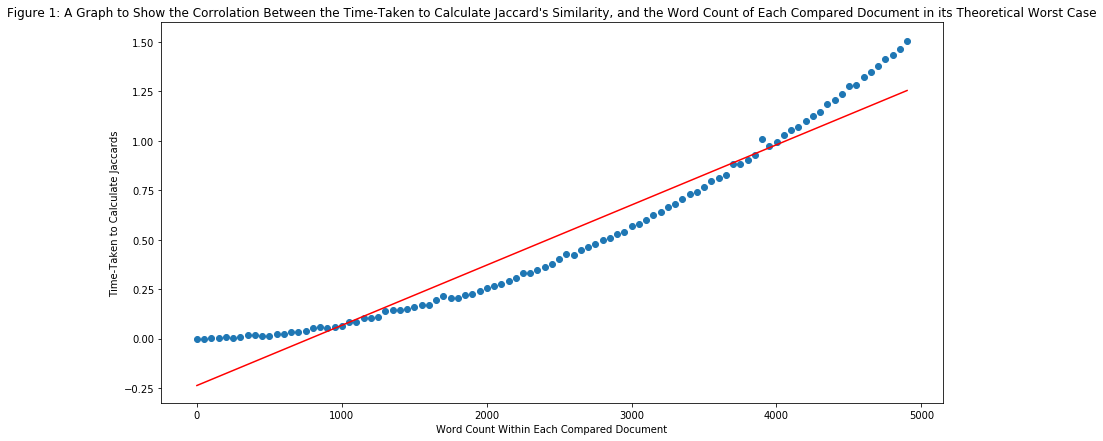

In [381]:
#---------------------------------------------Jaccards bow Dict Worst Case--------------------------------------------------
title = "Figure 1: A Graph to Show the Corrolation Between the Time-Taken to Calculate Jaccard's Similarity, and the Word Count of Each Compared Document in its Theoretical Worst Case"
xlabel = "Word Count Within Each Compared Document"
ylabel = "Time-Taken to Calculate Jaccards"
plot_runtime('jaccards', 'dict', 5000, 50, title, xlabel, ylabel, True)#5000-50

$\qquad$Based on the above, the constants for the mimicked worst-case above appear to be as follows:

$$ RunTime = (6.02\times10^{-8})n^2 + (1.71\times10^{-5})n + (4.53\times10^{-3})$$

$\qquad$where $n$ = the word count within each document.

$\qquad$The below plot is much more representative of an average case. Due to the `if x in y` functions average runtime being constant, the overall trend now represents a linear runtime, as opposed to a quadratic one.

Current progress:  98.99 %
Average time:  0.008801335036152541  seconds
Gradient constant: 0.000001    R-squared (Coefficient of determination): 0.965754   Intercept: -0.000663


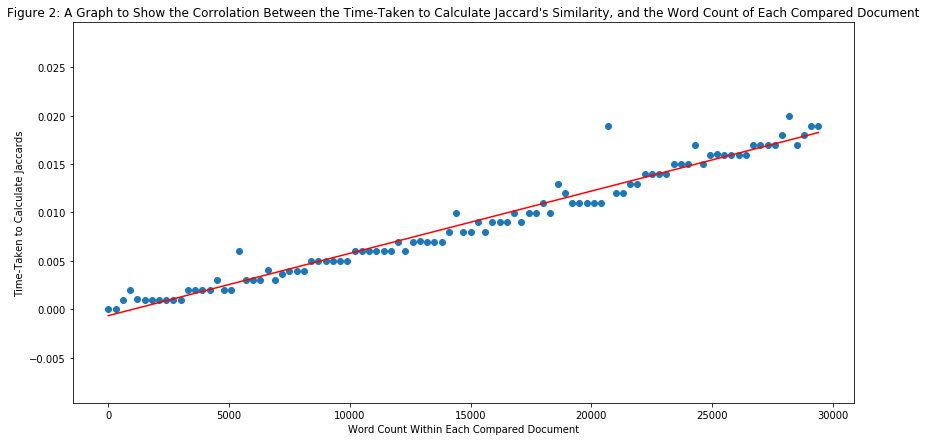

In [127]:
#---------------------------------------------------Jaccards bow Dict-----------------------------------------------------
title = "Figure 2: A Graph to Show the Corrolation Between the Time-Taken to Calculate Jaccard's Similarity, and the Word Count of Each Compared Document"
xlabel = "Word Count Within Each Compared Document"
ylabel = "Time-Taken to Calculate Jaccards"
plot_runtime('jaccards', 'dict', 30000, 300, title, xlabel, ylabel, False)

$\qquad$As you can see above, our regression line can be decribed as:

$$Time = 0.000001\times WordCount - 0.000663$$

$\qquad$The reason for such low constants is due to the very high speed of the computers this is being run on. Needless to say the negative intersection constant is erroenous, and is caused by the limitations of anaconda failing to differentiate between the first 4 plotted times, denoting them all as 0, causing the regression line to dip below the first one. In actuality this will be a very small number, so close to 0 that for our purposes we can simply round it to that. (Note that this is not underflow, but limitations imposed by the accuracy of anaconda's timer) 

### 2) What is the theoretical worst case running time of the cosine similarity measure applied to documents represented as (dense representation) vectors? Show that this is the case empirically. Estimate the constant for your implementation and computer. You may wish to compare using the implementation of the dot product in numpy with your own implementation. ###

$\qquad$The worst case running time of the cosine similarity measure with a vector representation is $O(n)$, this complexity stems from the `dot` function which calculates the dot product of two given vectors. In doing so it must iterate through every item within the vectors, this leads to a linear running time, as the number of operations that must be carried out is directly proportional to the size of the vectors in question. To demonstrate this empirically I once again made use of a variable called `totalOperations` to allow me to show the relationship between this, and the size of the matricies in question. You can see that these are equal, and the amount of operations scales up in a linear fashion in accordance with the input size.

In [32]:
def make_matrix(list_of_dicts):
    """
    Reformats a list of documents to vector format
    Params: list_of_dicts - a list of dictionaries, each representing a document
    Return: matrix - reformatted input documents, now as dense vector representation
    """
    allfeatures={}    
    for docdict in list_of_dicts:
        for feat in docdict.keys():
            allfeatures[feat]=1 
    dimensions=list(allfeatures.keys())
    sorted(dimensions)
    matrix=[]
    #each row in the matrix will be one of the dimensions
    for dimension in dimensions:
        row=[]
        #look up the appropriate value for each document
        for docdict in list_of_dicts:
            row.append(docdict.get(dimension,0)) #appends the document's value if present, 0 otherwise
        matrix.append(row)  
    return matrix

def transpose(matrix):
    """
    Transposes a matrix for the purpose of comparison
    Param: matrix - documents represented as a matrix
    Return: transposed - the same document representation transposed
    """
    transposed=[]
    for i in range(0,len(matrix[0])):
        transposed.append([row[i] for row in matrix]) 
    return transposed

def dict_to_vector(dict_list):
    """
    Re-formats data from a list of bag-of-words dictionaries to vector representation (sparse to dense representation)
    Params: dict_list - a list of documents, with each represented as a dictionary
    Return: docvectors - the same documents represented as vectors
    """
    amatrix=make_matrix(docs)
    docvectors=transpose(amatrix)
    return docvectors 

$\qquad$The code block above outlines three functions for the purpose of reformatting dictionary-based document representations to their vector-equivalents. Below they are all tested on a sample of 2 documents drawn from the Amazon Review text corpus, this is a more suitable test than on our random-string documents as to avoid a result of 0 regardless of which two documents are compared.

In [175]:
#Populates our document collection with 2 samples from the amazon review corpus
docs = populate_doc_collection('amazon', 2)
doc1 = docs[0]
doc2 = docs[1]

def dot(v1,v2):
    """
    A function to calculate the dot product beteen two vectors, to be used for calculating cosine similarity
    Params: v1, v2 - vectors to calculate dot product of
    Return: total - dot product of v1 and v2
            totaOperations - iterator variable used to empirically demonstrate running times
    """
    totalOperations = 0
    total=0
    for i in range(0,len(v1)):
        total+=v1[i]*v2[i] 
        totalOperations += 1
    return [total, totalOperations]

def cosine(v1,v2):    
    return round(dot(v1,v2)[0]/math.sqrt(dot(v1,v1)[0]*dot(v2,v2)[0]),4)

def npcosine(v1,v2):  
    v1 = np.array(v1)
    v2 = np.array(v2)
    return round(np.dot(v1,v2)/math.sqrt(np.dot(v1,v1)*np.dot(v2,v2)),4)

#Convert data from a dictionary to a vector representation
docvectors= dict_to_vector(docs)

#Print Output Data
print("Size of vector 1: ", len(docvectors[0]))
print("Size of vector 2: ", len(docvectors[1]))
print("Total Operations: ", dot(docvectors[0], docvectors[1])[1])
print("Cosine Similarity: ", cosine(docvectors[0],docvectors[1]))
print("Numpy Cosine Similarity: ", npcosine(docvectors[0],docvectors[1]))  

Size of vector 1:  143
Size of vector 2:  143
Total Operations:  143
Cosine Similarity:  0.5111
Numpy Cosine Similarity:  0.5111


Current progress:  98.99 %
Average time:  0.006612503167354699  seconds
Gradient constant: 0.000000    R-squared (Coefficient of determination): 0.986825   Intercept: 0.000169


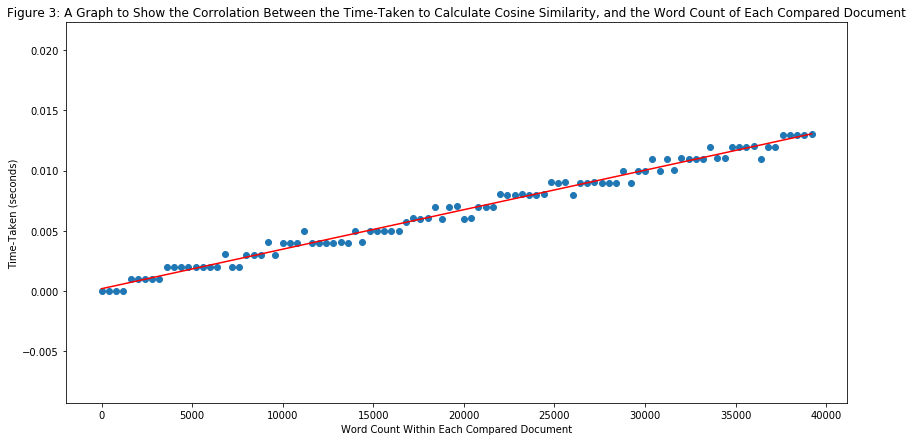

In [128]:
#---------------------------------------------------Cosine Vector-----------------------------------------------------
title = "Figure 3: A Graph to Show the Corrolation Between the Time-Taken to Calculate Cosine Similarity, and the Word Count of Each Compared Document"
xlabel = "Word Count Within Each Compared Document"
ylabel = "Time-Taken (seconds)"
plot_runtime('cosine', 'vector', 40000, 400, title, xlabel, ylabel, False)

Current progress:  98.99 %
Average time:  0.0016857060519131746  seconds
Gradient constant: 0.000000    R-squared (Coefficient of determination): 0.820357   Intercept: -0.000116


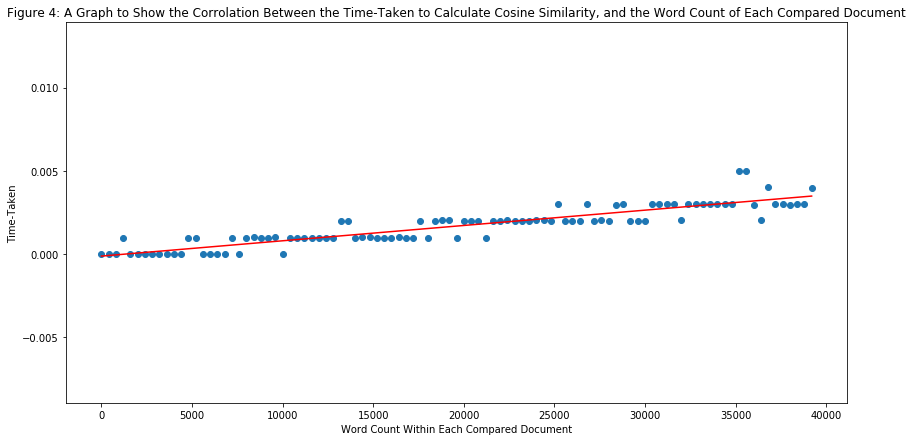

In [129]:
#-------------------------------------------------Numpy Cosine Vector-----------------------------------------------------
title = "Figure 4: A Graph to Show the Corrolation Between the Time-Taken to Calculate Cosine Similarity, and the Word Count of Each Compared Document"
xlabel = "Word Count Within Each Compared Document"
ylabel = "Time-Taken"
plot_runtime('npcosine', 'vector', 40000, 400, title, xlabel, ylabel, False)

$\qquad$Due to the sheer difference in magnitude of the `x` and `y` axis values, our gradient constants are so minute that they appear to be suffering from underflow and both displaying 0 - with such low constants any isolated operation may seem as if it has a constant running time, but as you can see from the graphs, this is not quite the case. Despite what the gradient constant is said to be, we can see the numpy dot-product implementation is faster with the lower gradient constant of the two. Being an in-built function using its native data type, it is better optimised for calculating dot products, which is where the complexity of cosine similarity stems from.

$\qquad$Our own implementation does seem to display less variance to its results, having the higher coefficient of determination of the two, whilst the numpy one seems to be much more prone to outliers. I anticipate this difference however, to be at largely due to the limitations imposed by the timing abilities of anaconda when faced with such incredibly short times. This is supported by the time-taken data almost appearing discrete rather than continuous, only incrementing in steps of 1 millisecond.

### 3) Write a function which computes cosine similarity directly from sparse (dictionary) representations without converting them into dense (vector) representations? Make sure you test your function empirically for correctness and for efficiency and compare it to your previous implementation of the cosine similarity and your implementation of Jaccard’s measure. ###

$\qquad$Below you can see my implementation to accomplish the same as that in section 2, however using a dictionary representation for documents as opposed to a vector one. At a high-level it is the same, actioning the same algorithm, however the syntax needed changing to cater to and operate on the different data type. When tested on the same documents it achieves the same result as the two vector implementations which serves as empirical evidence in support of its correctness. In addition, I compared pairs of documents from each the Amazon and Medline corpora, achieving an average similarity score of **0.504** (to 3.s.f), and as expected there was a notable drop (of **36%**) when carrying out a cross-corpora comparison.

$\qquad$The worst-case running time now however is $O(n^2)$, despite using the same high-level algorithm, this discrepancy is a result of the different data types being used. Whilst both lists and dictionaries have an average time complexity to their `get` operation of $O(1)$, in their worst case dictionaries deteriorate to $O(n)$ whilst lists do not (although again, this is highly unlikely).

In [177]:
#Initialize documents from 2 corpora for comparison
amazonDocs = populate_doc_collection('amazon')
doc1 = amazonDocs[0]
doc2 = amazonDocs[1]
medlineDocs = populate_doc_collection('medline')
doc3 = medlineDocs[0]
doc4 = medlineDocs[1]


def dot_dict(docA,docB):
    """
    Takes two dictionary documents and calculates their dot product
    Params: docA, docB - two documents, represented as dictionaries
    Returns: the_sum - the dot product of docA and docB
    """
    the_sum=0
    for (key,value) in docA.items():
        the_sum+=value*docB.get(key,0)
    return the_sum


def cos_dict(docA,docB):
    """
    Calculates the cosine similarity of two documents given as dictionaries
    Params: docA, docB - two documents, represented as dictionaries
    Returns: sim - the cosine similarity of docA and docB
    """
    sim=dot_dict(docA,docB)/(math.sqrt(dot_dict(docA,docA)*dot_dict(docB,docB)))
    return round(sim,4)

#Display outputs
print("Cosine Similarity of 2 Amazon reviews: ", cos_dict(doc1, doc2))
print("Cosine Similarity of 2 Medline texts: ", cos_dict(doc3, doc4))
print("Cosine Similarity of Amazon to Medline: ", cos_dict(doc1, doc4))

Cosine Similarity of 2 Amazon reviews:  0.5111
Cosine Similarity of 2 Medline texts:  0.4966
Cosine Similarity of Amazon to Medline:  0.3196


Current progress:  98.99 %
Average time:  0.01046313661517519  seconds
Gradient constant: 0.000001    R-squared (Coefficient of determination): 0.970969   Intercept: -0.000977


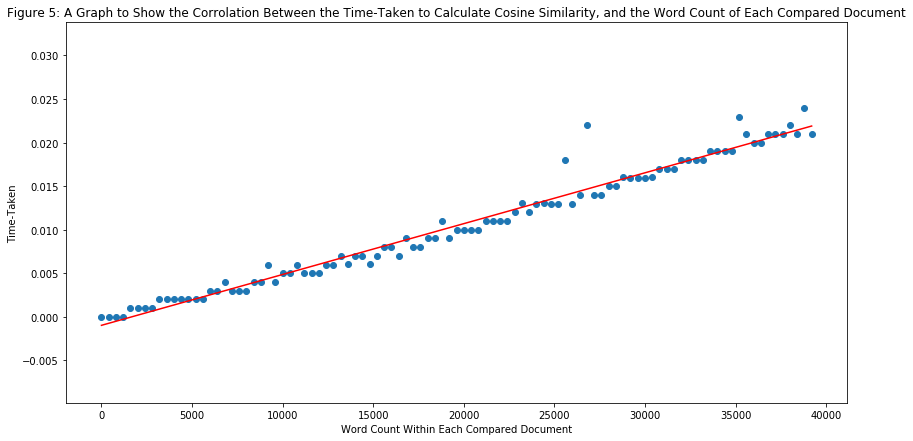

In [130]:
#------------------------------------------------- Cosine Dict-----------------------------------------------------
title = "Figure 5: A Graph to Show the Corrolation Between the Time-Taken to Calculate Cosine Similarity, and the Word Count of Each Compared Document"
xlabel = "Word Count Within Each Compared Document"
ylabel = "Time-Taken"
plot_runtime('cos_dict', 'dict', 40000, 400, title, xlabel, ylabel, False)

$\qquad$The implementation and computer specific constants for the above can be described as:

$$ RunTime = (1\times10^{-6})n - (1.04\times10^{-3})$$

$\qquad$Where $n$ = the word count within each document being compared.

$\qquad$Although comparison is made challenging by a combination of very fast running times, imperfect timing accuracy and the resulting small constants, at a glance it appears that the data-structure being used bears more impact than the algorithm of choice. Although the difference isn't significant, the above graph seems more representative of that from section 1 (of Jaccard's similarity with a dictionary representation) than those in section 2 (cosine with a vector representation). Those in section 2 with a vector representation average at 0.00415 seconds with a maximum document length of 40k, whilst those with dictionary representations are typically more than double that. This does support our evaluations of the comparative theoretical worst-case running times with each representation.

### 4) Write a function which computes all-pairs similarities for a collection of documents. The function should take a list of dictionaries (the document collection) and a parameter specifying the similarity measure to be used. What is the theoretical worst-case running time for computing all-pairs similarities? Does it matter what the similarity measure is? Can you give an estimate of how long it would take to compute all-pairs similarities for 200K documents for both measures? (Note: that whilst you should test your function for all-pairs similarities (with d > 10), you do not need to prove the theoretical worst case empirically or test with 200K documents!) ###

$\qquad$Below you can see the function `all-pairs`, which as per the above requirements, takes two parameters - `docs`, a collection of documents (represented as dictionaries), as well as `measure` which denotes the similariy measure to be used. The function then computes the all-pairs similarites within the given document collection, of the given measure.

$\qquad$We have already established that although it is very unlikely, dictionaries have a linear $O(n)$ worst-case run time with a `get` operation. As a result, the theoretical worst-case running times of calculating the similarity of two documents represented as dictionaries is $O(n^2)$ regardless if done so using Jaccard's or the Cosine measure.

$\qquad$One therefore may jump to the conclusion that calculating the `all-pairs` similarity of a collection of documents using these methods is $O(n^4)$ as $n^2 \times n^2 = n^4$ provided that the documents are being represented as dictionaries. Whilst the $n$ in the $O(n^2)$ running time of jaccards/cosine refers to the amount of words within a document, the $n$ in `all-pairs`' $O(n^2)$ refers to the amount of documents in the collection - they are different constants. If we refer to the amount of words in a document as $w$, we now get $O(n^2\cdot w^2)$, in an average case the $w$ (referring to number of words within each document) is an order of magnitude less significant than $n$, and for the same reason constants quickly become obsolete in big $O$ notation, so does the $w^2$ in this case, leaving us with an overall average case running-time of $O(n^2)$ for `all-pairs`.The *theoretical* worst-case however is $O(n^4)$ - as the amount of words in each document tends towards infinity, this $w^2$ run-time of the similarity measure is significant.

$\qquad$Big $O$ notation is only concerned with how the runtime changes as the **size** of the input is increased, we are dealing with a 2-dimensional input, if we only increased it in one dimension (amount of documents in collection) it would result in a worst case of $O(n^2)$, however this is squared if we increase the size of both dimensions towards infinity (inc. word count per document).

In [43]:
#Creates lists of dictionaries from each corpora
amazon = populate_doc_collection('amazon', docCount=50)

def all_pairs(docs, measure):
    """
    A nested-loop function to calculate the similarities between all possible pair permutations within a document collection
    Params: docs - the document collection with which to calculate all-pairs similarity
            measure - the similarity measure to be used, cosine/jaccards
    Return: similarities - the similarities of every possible pair of documents within docs
    """
    similarities = []
    for docA in docs:
        for docB in docs:
            if measure == 'cosine':
                similarities.append(cos_dict(docA, docB))
            elif measure == 'jaccard':
                similarities.append(jaccard(docA,docB)[0])
    return similarities      

starttime=time.time() #start the stopwatch
all_pairs(amazon, 'cosine')
endtime=time.time() #stop the stopwatch
timetaken=endtime-starttime
print("Time taken was {}s".format(timetaken))

Time taken was 0.13692450523376465s


In [42]:
def timed_all_pairs(docs, measure):
    """
    A simple function to time an all-pairs similarity measure
    Params: docs - the document collection of which to compute pairwise similarity
            measure - the similarity measure to be used, cosine/jaccards
    Rerurm: timetake - the time taken for the calculation
    """
    starttime=time.time()   
    all_pairs(docs, measure)   
    endtime=time.time()
    timetaken=endtime-starttime
    return timetaken

Current progress:  95.0 %


Text(0.5, 0, 'Documents in collection')

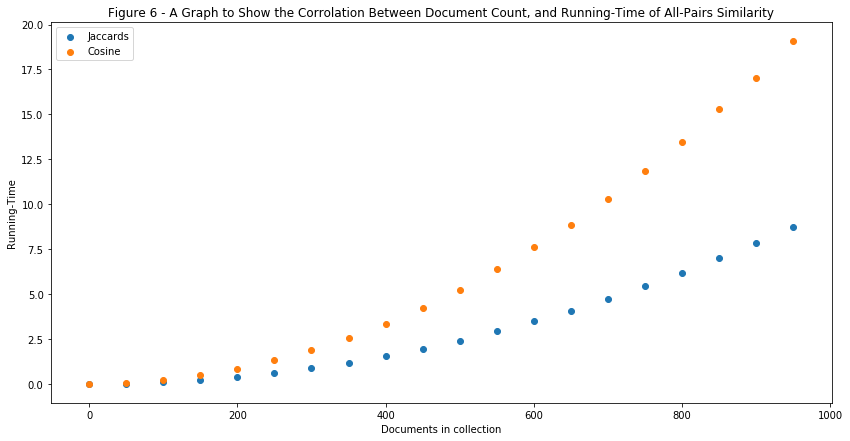

In [44]:
jaccard_times, cos_times, docCount = [], [], []

#Sampe doc collection up to size 1000, incrementing every 50
for i in range(0, 1000, 50):
    clear_output(wait=True)
    docs = fixedCollection(i)
    jaccard_times.append(timed_all_pairs(docs, 'jaccard'))
    cos_times.append(timed_all_pairs(docs, 'cosine'))
    docCount.append(i)
    print("Current progress: ",np.round(i/1000 *100, 2), "%")
    
#Plot results
plt.figure(figsize=(14,7))
plt.scatter(docCount, jaccard_times, label='Jaccards')
plt.scatter(docCount, cos_times, label='Cosine')
plt.legend()
plt.title("Figure 6 - A Graph to Show the Corrolation Between Document Count, and Running-Time of All-Pairs Similarity")
plt.ylabel("Running-Time")
plt.xlabel("Documents in collection")

$\qquad$In order to estimate the running time of `all-pairs` with a collection of 200k documents, we need to create a model mapping `x` (Documents in collection) and `y` (Running-Time). To do this we must take logs of both, allowing us to map the above curves to a linear equivalent.

Jaccard's:
Gradient constant: 1.943307    R-squared (Coefficient of determination): 0.999761   Intercept: -4.855652
Cosine:
Gradient constant: 1.970339    R-squared (Coefficient of determination): 0.999803   Intercept: -4.594406


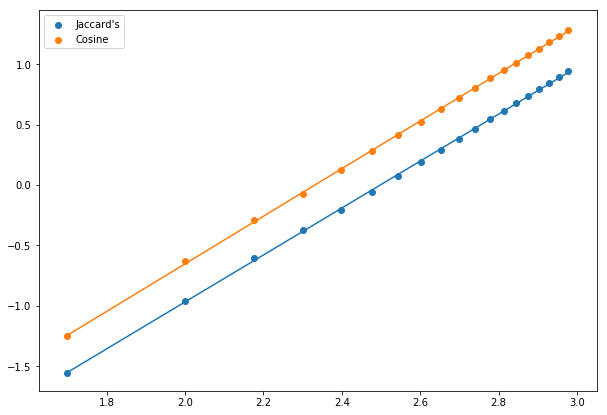

In [82]:
#Takes logs to map curve on to linear plot
logX = [np.log10(val) for val in docCount[1:]]
logY_jaccard = [np.log10(val) for val in jaccard_times[1:]]
logY_cos = [np.log10(val) for val in cos_times[1:]]
#Plots results
plt.figure(figsize=(10,7))
plt.scatter(logX,logY_jaccard, label="Jaccard's")
plt.scatter(logX,logY_cos, label='Cosine')
plt.legend()
#Plots polyfit line
plt.plot(np.unique(logX),np.poly1d(np.polyfit(logX,logY_jaccard,1))(np.unique(logX)))
plt.plot(np.unique(logX),np.poly1d(np.polyfit(logX,logY_cos,1))(np.unique(logX)))

#Calculates regression line constants
slope, intercept, r_value, p_value, std_err = stats.linregress(logX, logY_jaccard)
print("Jaccard's:")
print("Gradient constant: %f    R-squared (Coefficient of determination): %f   Intercept: %f" % (slope, r_value**2, intercept))
slope, intercept, r_value, p_value, std_err = stats.linregress(logX, logY_cos)
print("Cosine:")
print("Gradient constant: %f    R-squared (Coefficient of determination): %f   Intercept: %f" % (slope, r_value**2, intercept))

The gradients can be rounded to 2 which serves as empirical evidence of the $O(n^2)$ running time, note they are slightly below due to some operations being excecuted outside the main loop. 

Since: $$log(f(x))=log(a)+b\cdot log(x)$$

and in the case of **Jaccard's**, $b = 2$ and $a= 10^{-4.86} = 1.39\times10^{-5}$

$$RunTime = (1.39\times10^{-5})\times DocCount^2$$

With a document count of **200k**, the estimated running time can be given by:

$$RunTime = (1.39\times10^{-5})\times 200,000^2$$
$$ = 55600 \; Seconds$$
$$= 6.4 \; Days $$

In the case of **Cosine**, $b = 2$ and $a= 10^{-4.59} = 2.54\times10^{-5}$

$$RunTime = (2.54\times10^{-5})\times 200,000^2$$
$$ = 1016000 \; Seconds$$
$$= 11.7 \; Days $$

### 5) Use the map-reduce computing paradigm to implement a parallel version of all-pairs similarities for documents. Make sure you test your function empirically for correctness and for efficiency. Investigate the number of map processes and reduce processes which give optimal results for your implementation and computer. ###

$\qquad$The diagram below [1] illustrates how pairwise document similarity in large collections can be calculated, with significantly more speed and efficiency than we have seen above, using the map-reduce computing paradigm. The key for this implementation is to use map-reduce twice, the first of which produces a standard inverted index, before the second uses that to calculate the pairwise similarity.

$\qquad$The initial mapper function creates a dictionary data structure for each unique word in an input document, the word being the key, and the associated value being its frequency. Where this differs from the implementation found in the Lab_11 solution is that this value now also needs to be coupled with a document index, from which this word was found with the stored frequency. These are then reduced together, grouped by key, causing the shuffling illustrated below. We now have the inverted index where each term is associated with a list of document indexes, and respective occurences.

$\qquad$The second mapper function then transforms this in to a tuple of two document indexes (collectively making up the key), with an associated word-specific count of the relationships between the two denoted documents. For example, if word 'A' appears once in one document, and twice in another, this will result in a value of 2, as the word can be equated twice between the documents - once from the first document, to each instance in the second document. The final reducer once again groups the data together by the key, totalling all values that share a key, resulting in the total amount of shared words between every possible combination of the original documents, i.e all-pairs similarity.

![title](MapReduce_pairwiseSim.jpg)

In [141]:
d1= ["A", "A", "B", "C"]
d2=["B", "D", "D"]
d3=["A", "B", "B", "E"]

collection=[]
collection.append(d1)
collection.append(d2)
collection.append(d3)
print(collection)

[['A', 'A', 'B', 'C'], ['B', 'D', 'D'], ['A', 'B', 'B', 'E']]


In [207]:
#import operator
from multiprocessing import Pool
from collections import defaultdict


def map_reduce_parallel(inputs,mapper,reducer,mapprocesses=1,reduceprocesses=1):
    
    collector=defaultdict(list)  #this dictionary is where we will store intermediate results
                                 #it will map keys to lists of values (default value of a list is [])
                                 #in a real system, this would be stored in individual files at the map nodes
                                 #and then transferred to the reduce nodes 
    mappool = Pool(processes=mapprocesses)
    #map stage
    mapresults=mappool.map(mapper,inputs)
    mappool.close()
    print(mapresults)  
           
    for (key, value) in mapresults:     #pass each input to the mapper function and receive back each key,value pair yielded
        collector[key].append(value)     #append the value to the list for that key in the intermediate store
    
    #reduce stage - 1 reducer for each key
    outputs=[]
    reducepool = Pool(processes=reduceprocesses)
    
    reduceresults=reducepool.map(reducer,mapresults)
    #reduceresults=reducepool.map(reducer,collector.items())
    reducepool.close()
    for reduceresult in reduceresults:
        outputs+=reduceresult
    print(outputs)
    return outputs

def wc_reducer_parrallel(mapped_items):
    collector={}
    
    for item in mapped_items:
        for (key, val) in item.items():
            collector[key] = []            
    for item in mapped_items:
        for (key, val) in item.items():
            for (k1, v1) in collector.items():
                if key == k1:
                    collector[k1].append(val)
    return collector

def wc_mapper_parallel(collection):
    output=[]
    for i in range(len(collection)):
        document = {}
        for word in collection[i]:
            x = document.get(word,0)
            if x == 0:
                document[word]=(i, document.get(word,0)+1)
            else:
                 document[word]=(i,document.get(word)[1]+1)
        output.append(document)
    return output

# def wc_mapper_parallel_2(items):
#     output={}
#     print(items.values())
#     for grouping in items.values():  
#         print(grouping)
#         print(grouping[0][0])
#         print(grouping[1][0])
#         if len(grouping)>1:
#             output[grouping[0][0],grouping[1][0]] = max(grouping[0][1],grouping[1][1])
#             print(output[grouping[0][0],grouping[1][0]])
#     print("Output: ", output)
#     return output

         
firstMapping = wc_mapper_parallel(collection)
invertedIndex = wc_reducer_parrallel(intermediateResults)
# secondMapping = wc_mapper_parallel_2(invertedIndex)
print("First Mapping: ")
print(firstMapping)
print("Inverted Index: ")
print(invertedIndex)
# print("Second Mapping: ")
# print(secondMapping)
# print("Second Reduction: ")
# print(allPairs)

First Mapping: 
[{'A': (0, 2), 'B': (0, 1), 'C': (0, 1)}, {'B': (1, 1), 'D': (1, 2)}, {'A': (2, 1), 'B': (2, 2), 'E': (2, 1)}]
Inverted Index: 
{'A': [(0, 2), (2, 1)], 'B': [(0, 1), (1, 1), (2, 2)], 'C': [(0, 1)], 'D': [(1, 2)], 'E': [(2, 1)]}


In [159]:
def convertToListOfStrings(documents):
    """
    Whilst the above serves as a proof of concept true to the diagram, this function converts our amazon bag-of-words 
    dictionary to a list of lists of tokens to allow testing on an actual text corpora.
    Params: documents - a document stored as a dictionary
    Return: stringDocs - the same document reformatted as a list of strings
    """
    stringDocs = []
    for doc in documents: #Iterates through each document
        my_string = "" #Initialise empty string to represent each doc
        for (word,val) in doc.items(): #add each word to a string followed by a whitespace
            my_string += word
            my_string += " "
        stringDocs.append(my_string) #Append each string to list
        #print(stringDocs)
    return stringDocs

#Tokenizes resulting string
untokenized = convertToListOfStrings(populate_doc_collection('amazon', docCount=3))
amazon = []     
for i in range(len(untokenized)):
    amazon.append(word_tokenize(untokenized[i]))  
print(amazon)

[['THis', 'book', 'was', 'horrible', '.', 'If', 'it', 'possible', 'to', 'rate', 'lower', 'than', 'one', 'star', 'i', 'would', 'have', 'I', 'am', 'an', 'avid', 'reader', 'and', 'picked', 'this', 'up', 'after', 'my', 'mom', 'had', 'gotten', 'from', 'a', 'friend', 'read', 'half', 'of', ',', 'suffering', 'headache', 'the', 'entire', 'time', 'then', 'got', 'part', 'about', 'relationship', '13', 'year', 'old', 'boy', 'with', '33', 'man', 'lit', 'on', 'fire', 'One', 'less', 'copy', 'in', 'world', '...', 'do', "n't", 'waste', 'your', 'money', 'wish', 'spent', 'reading', 'back', 'so', 'could', 'use', 'for', 'better', 'purposes', 'wasted', 'life'], ['I', 'like', 'to', 'use', 'the', 'Amazon', 'reviews', 'when', 'purchasing', 'books', ',', 'especially', 'alert', 'for', 'dissenting', 'perceptions', 'about', 'higly', 'rated', 'items', 'which', 'usually', 'disuades', 'me', 'from', 'a', 'selection', '.', 'So', 'offer', 'this', 'review', 'that', 'seriously', 'questions', 'popularity', 'of', 'work', '-'

In [163]:
mappedResults = wc_mapper_parallel(amazon)
print(mappedResults)

[{'THis': (0, 1), 'book': (0, 1), 'was': (0, 1), 'horrible': (0, 1), '.': (0, 1), 'If': (0, 1), 'it': (0, 1), 'possible': (0, 1), 'to': (0, 1), 'rate': (0, 1), 'lower': (0, 1), 'than': (0, 1), 'one': (0, 1), 'star': (0, 1), 'i': (0, 1), 'would': (0, 1), 'have': (0, 1), 'I': (0, 1), 'am': (0, 1), 'an': (0, 1), 'avid': (0, 1), 'reader': (0, 1), 'and': (0, 1), 'picked': (0, 1), 'this': (0, 1), 'up': (0, 1), 'after': (0, 1), 'my': (0, 1), 'mom': (0, 1), 'had': (0, 1), 'gotten': (0, 1), 'from': (0, 1), 'a': (0, 1), 'friend': (0, 1), 'read': (0, 1), 'half': (0, 1), 'of': (0, 1), ',': (0, 1), 'suffering': (0, 1), 'headache': (0, 1), 'the': (0, 1), 'entire': (0, 1), 'time': (0, 1), 'then': (0, 1), 'got': (0, 1), 'part': (0, 1), 'about': (0, 1), 'relationship': (0, 1), '13': (0, 1), 'year': (0, 1), 'old': (0, 1), 'boy': (0, 1), 'with': (0, 1), '33': (0, 1), 'man': (0, 1), 'lit': (0, 1), 'on': (0, 1), 'fire': (0, 1), 'One': (0, 1), 'less': (0, 1), 'copy': (0, 1), 'in': (0, 1), 'world': (0, 1), '

In [165]:
invertedIndex = wc_reducer_parrallel(mappedResults)
print(invertedIndex)

{'THis': [(0, 1), (2, 1)], 'book': [(0, 1), (1, 1), (2, 1)], 'was': [(0, 1), (1, 1), (2, 1)], 'horrible': [(0, 1), (2, 1)], '.': [(0, 1), (1, 1), (2, 1)], 'If': [(0, 1), (2, 1)], 'it': [(0, 1), (1, 1), (2, 1)], 'possible': [(0, 1), (2, 1)], 'to': [(0, 1), (1, 1), (2, 1)], 'rate': [(0, 1), (2, 1)], 'lower': [(0, 1), (2, 1)], 'than': [(0, 1), (2, 1)], 'one': [(0, 1), (2, 1)], 'star': [(0, 1), (2, 1)], 'i': [(0, 1), (2, 1)], 'would': [(0, 1), (2, 1)], 'have': [(0, 1), (2, 1)], 'I': [(0, 1), (1, 1), (2, 1)], 'am': [(0, 1), (2, 1)], 'an': [(0, 1), (2, 1)], 'avid': [(0, 1), (2, 1)], 'reader': [(0, 1), (2, 1)], 'and': [(0, 1), (1, 1), (2, 1)], 'picked': [(0, 1), (2, 1)], 'this': [(0, 1), (1, 1), (2, 1)], 'up': [(0, 1), (2, 1)], 'after': [(0, 1), (2, 1)], 'my': [(0, 1), (2, 1)], 'mom': [(0, 1), (2, 1)], 'had': [(0, 1), (2, 1)], 'gotten': [(0, 1), (2, 1)], 'from': [(0, 1), (1, 1), (2, 1)], 'a': [(0, 1), (1, 1), (2, 1)], 'friend': [(0, 1), (2, 1)], 'read': [(0, 1), (2, 1)], 'half': [(0, 1), (2, 

**References:**

**[1]** - J. L. D. W. O. Tamer Elsayed, "Pairwise Document Similarity in Large Collections with MapReduce," in Proceedings of ACL-08: HLT, Short Papers (Companion Volume), pages 265–268, Columbus, Ohio, USA,, 2008. 

In [209]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of xxx

import io
from nbformat import current

filepath="Coursework_1.ipynb"
question_count=325

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 2146
